# Predicting life expectancy from World Bank data

The World Bank reports a massive amount of [Environment, Social, And Governance (ESG)](https://datacatalog.worldbank.org/dataset/environment-social-and-governance-data) data  for numerous countries and geographical regions. The World Bank's [sustainable development goals](https://datatopics.worldbank.org/world-development-indicators/wdi-and-the-sustainable-development-goals.html) aim to improve these measures in order to improve the well-being of populations.

For me, it is fascinating that this myriad of measures can have such a significant impact on the well-being of populations. How does one measure well-being? One rough proxy is lifespan. Obviously, factors such as clean water and good healthcare can affect lifespan; but we are discovering that even factors such as [intergenerational stress](https://epigeneticsandchromatin.biomedcentral.com/articles/10.1186/s13072-017-0145-1) can have an effect on lifespan. 

In this project, I explored the relationship between sustainable development indicators reported by the World Bank and life expectancy. I perform mutiliniear regression and create a model to predict country-wide mean life expectancy using variables reported in the ESG dataset.

## Setup
Install/attach required packages

In [ ]:
p<-.libPaths() #where your packages are installed 
`%notin%` <- Negate(`%in%`)

pkgs<-c('dplyr', 'tidyr', 'ggplot2', 'corrplot', 'psych', 'plotly') # packages needed for this project

for (i in 1:length(pkgs)){
  pkg<-pkgs[[i]]
  if (pkg %notin% rownames(installed.packages())){
    install.packages(pkg, p)
  }
  if (pkg %in% rownames(installed.packages()) & pkg %notin% loadedNamespaces()){
    library(pkg, character.only = T)
    print(paste("Attaching package:", pkg))
  }
  if (pkg %notin% rownames(installed.packages())){
    print(paste("Error installing ", pkg, ". Check Warnings."))
  }
}

# Load the data from the data folder

In [66]:
header<- read.csv("../data/ESGData.csv", nrows = 1) # load the header separately
wb <- read.csv("../data/ESGData.csv", header= FALSE, skip = 3084) # load the data itself
colnames(wb)<-colnames(header) # assign column names
rm(header) #clean up by removing extra assignment

print(paste("The WB dataframe has", dim(wb)[1], "rows and", dim(wb)[2], "columns"))
head(wb)

[1] "The WB dataframe has 14538 rows and 65 columns"


Country.Name,Country.Code,Indicator.Name,Indicator.Code,X1960,X1961,X1962,X1963,X1964,X1965,...,X2011,X2012,X2013,X2014,X2015,X2016,X2017,X2018,X2040,X
Afghanistan,AFG,Access to electricity (% of population),EG.ELC.ACCS.ZS,NA,NA,NA,NA,NA,NA,...,43.2220189,69.1000000,70.1534805,89.5000000,71.5000000,97.7000000,97.7000000,NA,NA,NA
Afghanistan,AFG,Adjusted savings: natural resources depletion (% of GNI),NY.ADJ.DRES.GN.ZS,NA,NA,NA,NA,NA,NA,...,0.3211679,0.3220366,0.2231001,0.2259098,0.2309967,0.2991603,0.3169646,NA,NA,NA
Afghanistan,AFG,Adjusted savings: net forest depletion (% of GNI),NY.ADJ.DFOR.GN.ZS,NA,NA,NA,NA,NA,NA,...,0.1806410,0.1556279,0.1529173,0.1586292,0.1814527,0.2291977,0.2263378,NA,NA,NA
Afghanistan,AFG,Agricultural land (% of land area),AG.LND.AGRI.ZS,NA,57.74592,57.83782,57.91441,58.01091,58.01397,...,58.0675796,58.0675796,58.0675796,58.0675796,58.0675796,58.0675796,NA,NA,NA,NA
Afghanistan,AFG,"Agriculture, forestry, and fishing, value added (% of GDP)",NV.AGR.TOTL.ZS,NA,NA,NA,NA,NA,NA,...,23.7436640,24.3908736,22.8106627,22.1370414,20.6343227,21.0810862,20.4665052,NA,NA,NA
Afghanistan,AFG,"Annual freshwater withdrawals, total (% of internal resources)",ER.H2O.FWTL.ZS,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In this dataframe, the columns represent a measure of an Indicator from the 'Indicator.Name' column, every year from 1960 onwards. 
## The code below tidies and averages indicator values accross years.
First, I only want to look at current years. Also, since there are many missing values in the data, I decided to average measurements per country over 2013-2017. 



In [20]:
wb_tidy<-wb%>% 
  select(Country.Name, Indicator.Name, X2013, X2014, X2015, X2016, X2017)%>% # select recent years
  droplevels()%>% # reset index
  gather(Year, Value, -Country.Name, -Indicator.Name)%>%    # make 1 row for each year for each indicator
  group_by(Country.Name, Indicator.Name)%>%  # group by country and indicator and average the value over all years listed 
  summarise(Avg.Value=mean(Value, na.rm = TRUE))%>%
  spread(Indicator.Name, Avg.Value) # make each row one country and each column a different indicator

# List all the indicators
print('INDICATOR NAMES:')
colnames(wb_tidy)

[1] "INDICATOR NAMES:"


[1] "Country.Name"                                                                                             
 [2] "Access to clean fuels and technologies for cooking (% of population)"                                     
 [3] "Access to electricity (% of population)"                                                                  
 [4] "Adjusted savings: natural resources depletion (% of GNI)"                                                 
 [5] "Adjusted savings: net forest depletion (% of GNI)"                                                        
 [6] "Agricultural land (% of land area)"                                                                       
 [7] "Agriculture, forestry, and fishing, value added (% of GDP)"                                               
 [8] "Annual freshwater withdrawals, total (% of internal resources)"                                           
 [9] "Annualized average growth rate in per capita real survey mean consumption or income, total population (%)"
[10] "Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)"    
[11] "Children in employment, total (% of children ages 7-14)"                                                  
[12] "CO2 emissions (metric tons per capita)"                                                                   
[13] "Control of Corruption: Estimate"                                                                          
[14] "Cooling Degree Days"                                                                                      
[15] "Droughts, floods, extreme temperatures (% of population, average 1990-2009)"                              
[16] "Ease of doing business index (1=most business-friendly regulations)"                                      
[17] "Electricity production from coal sources (% of total)"                                                    
[18] "Energy imports, net (% of energy use)"                                                                    
[19] "Energy intensity level of primary energy (MJ/$2011 PPP GDP)"                                              
[20] "Energy use (kg of oil equivalent per capita)"                                                             
[21] "Fertility rate, total (births per woman)"                                                                 
[22] "Food production index (2004-2006 = 100)"                                                                  
[23] "Forest area (% of land area)"                                                                             
[24] "Fossil fuel energy consumption (% of total)"                                                              
[25] "GDP growth (annual %)"                                                                                    
[26] "GHG net emissions/removals by LUCF (Mt of CO2 equivalent)"                                                
[27] "GINI index (World Bank estimate)"                                                                         
[28] "Government Effectiveness: Estimate"                                                                       
[29] "Government expenditure on education, total (% of government expenditure)"                                 
[30] "Health Index 35"                                                                                          
[31] "Hospital beds (per 1,000 people)"                                                                         
[32] "Income share held by lowest 20%"                                                                          
[33] "Individuals using the Internet (% of population)"                                                         
[34] "Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)"          
[35] "Life expectancy at birth, total (years)"                                                                  
[36] "Literacy rate, adult total (% of people 

## The code below creates a new data frame with the data selected for regression analysis.

I took a look at how many NAs were in each variable and selected some variables with minimal missing values to use for further analysis. 

In [21]:
wb_select <- wb_tidy%>%
  select(c(Country.Name,  #select columns
           `Renewable electricity output (% of total electricity output)`,
           `Access to electricity (% of population)`, 
           `Renewable energy consumption (% of total final energy consumption)`,
           `Terrestrial and marine protected areas (% of total territorial area)`, 
           `Agricultural land (% of land area)`,  
           `Individuals using the Internet (% of population)`,
           `CO2 emissions (metric tons per capita)`, 
           `GDP growth (annual %)`,
           `Political Stability and Absence of Violence/Terrorism: Estimate`,
           `Rule of Law: Estimate`,
           `Government Effectiveness: Estimate`,
           `PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)`,
           `Proportion of seats held by women in national parliaments (%)`,
           `Access to clean fuels and technologies for cooking (% of population)`,
           `Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)`,
           `Unemployment, total (% of total labor force) (modeled ILO estimate)`,
           `School enrollment, primary (% gross)`,
           `Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)`,
           `Adjusted savings: natural resources depletion (% of GNI)`,
           `Prevalence of undernourishment (% of population)`,
           `Life expectancy at birth, total (years)`))%>%
  na.omit()%>%  # remove NAs
  ungroup()

## Next, we'll visually explore the data and check for skewness. 

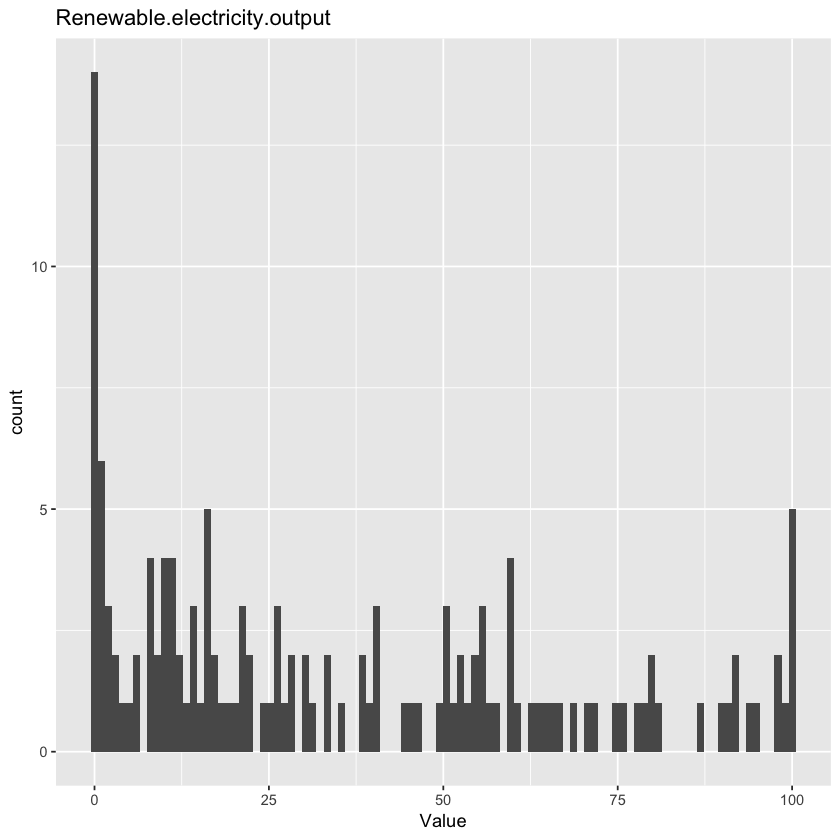

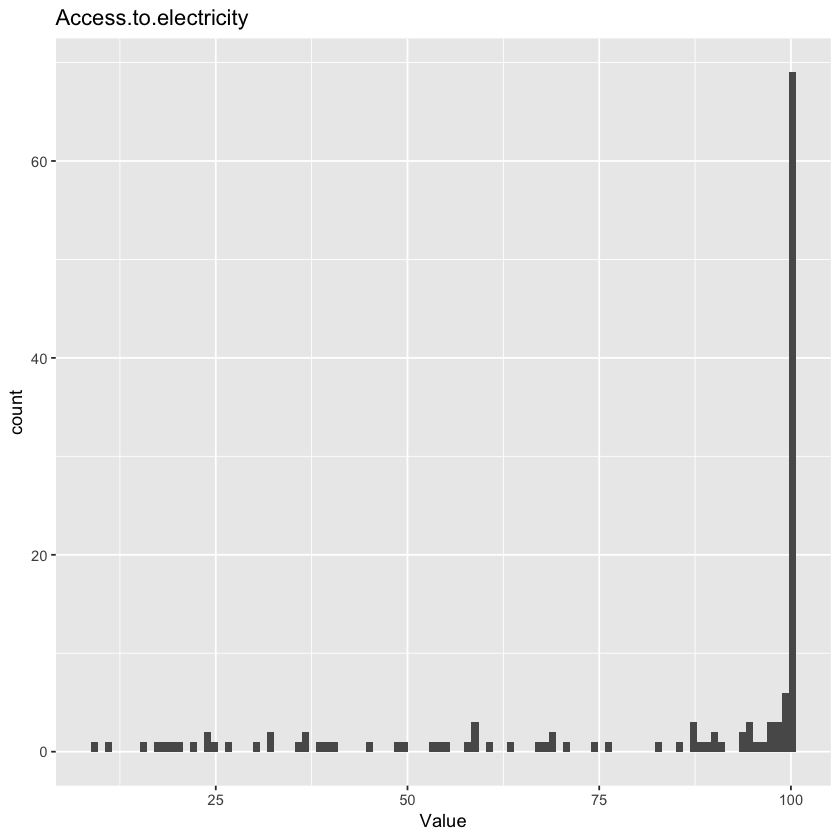

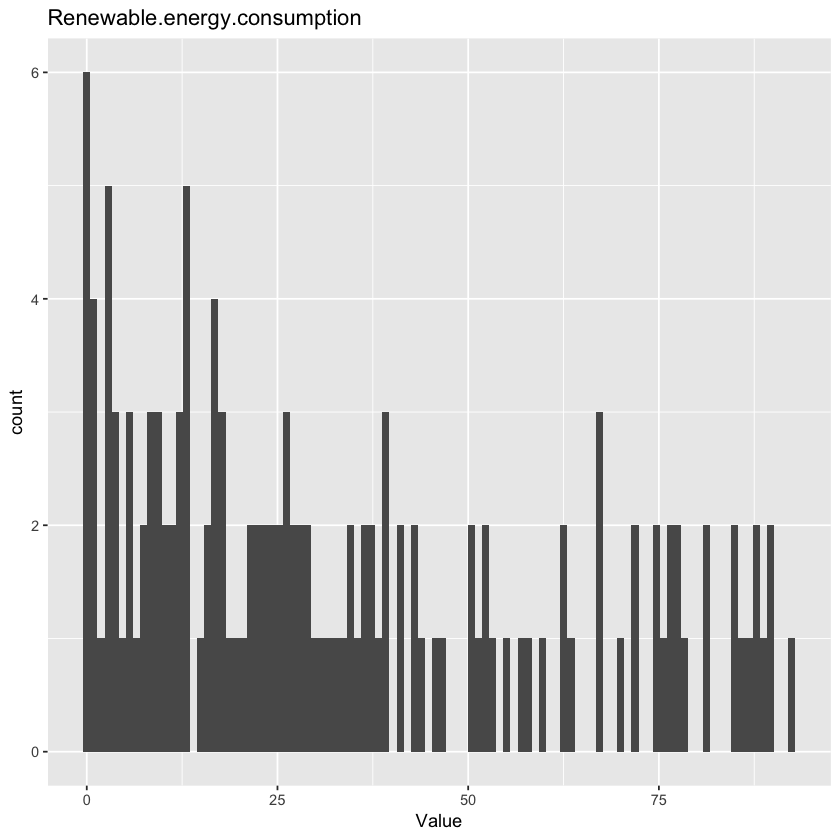

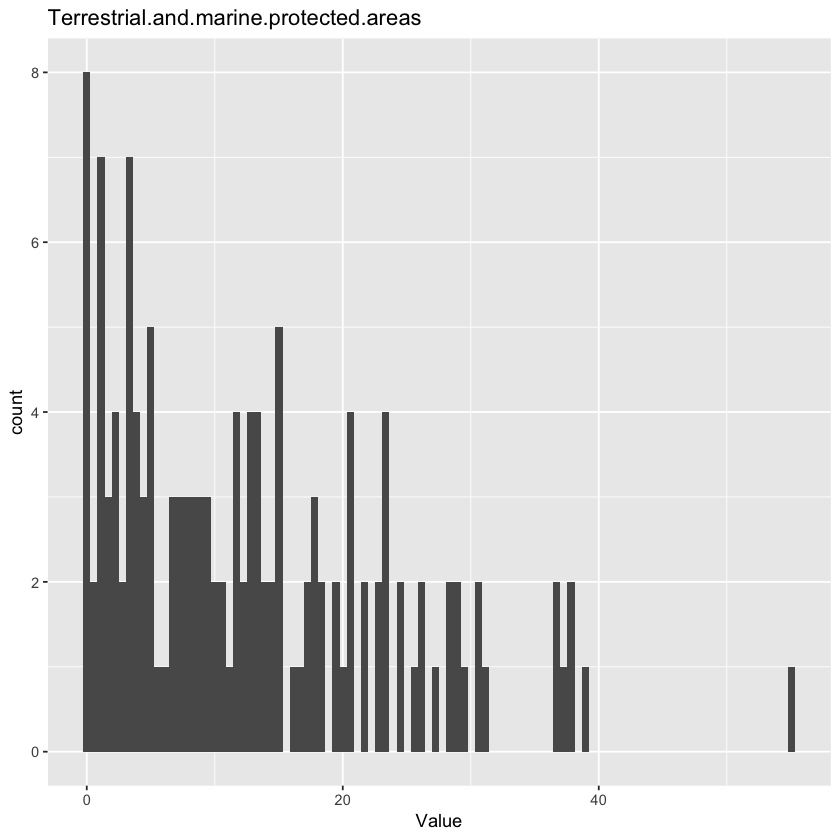

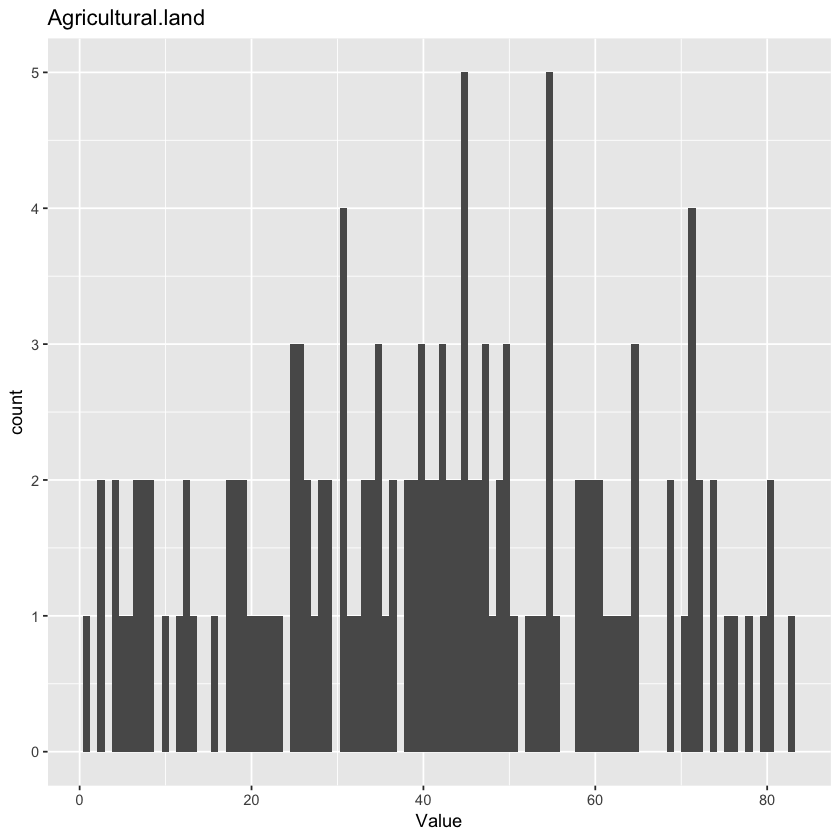

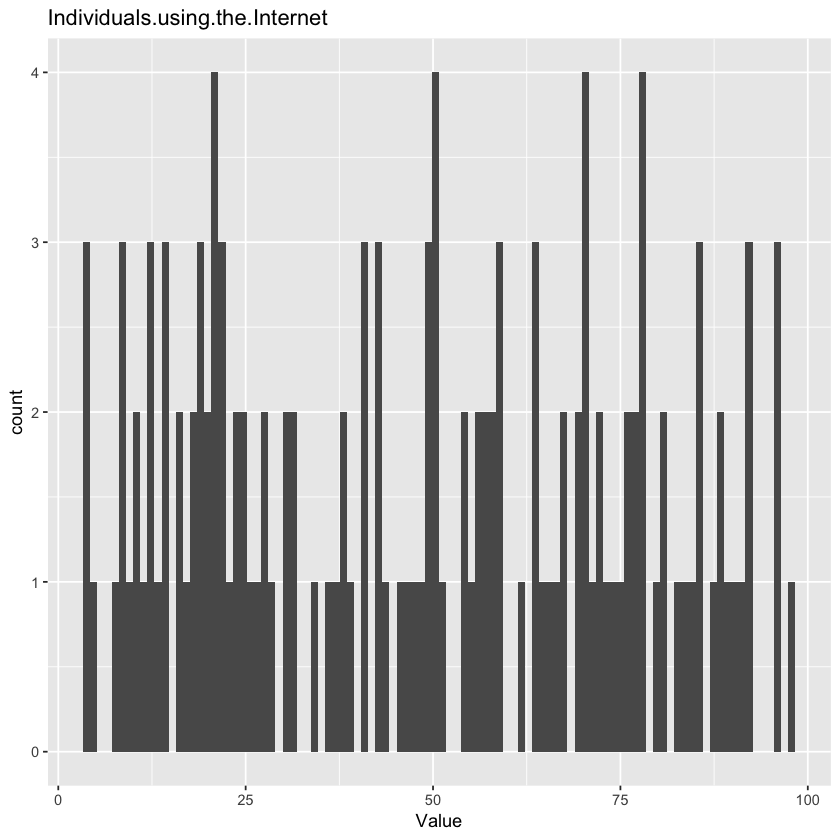

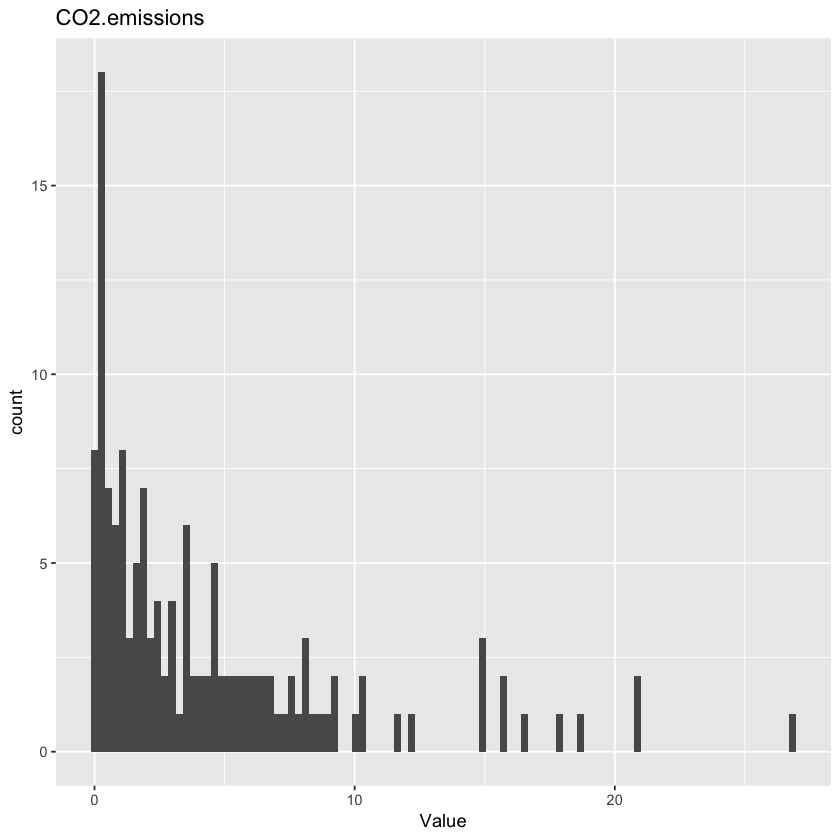

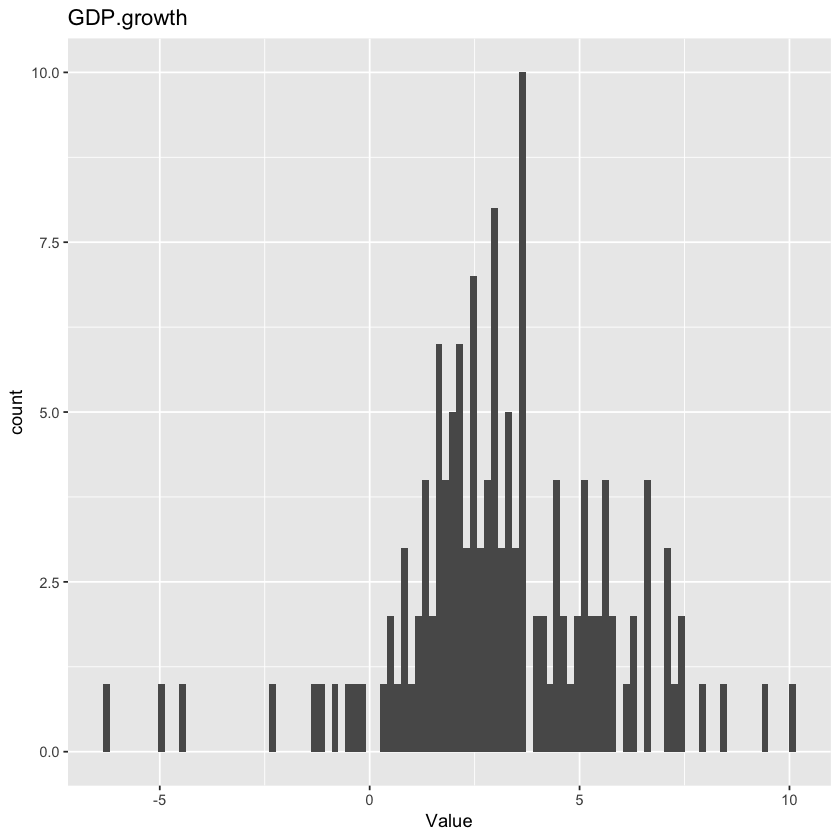

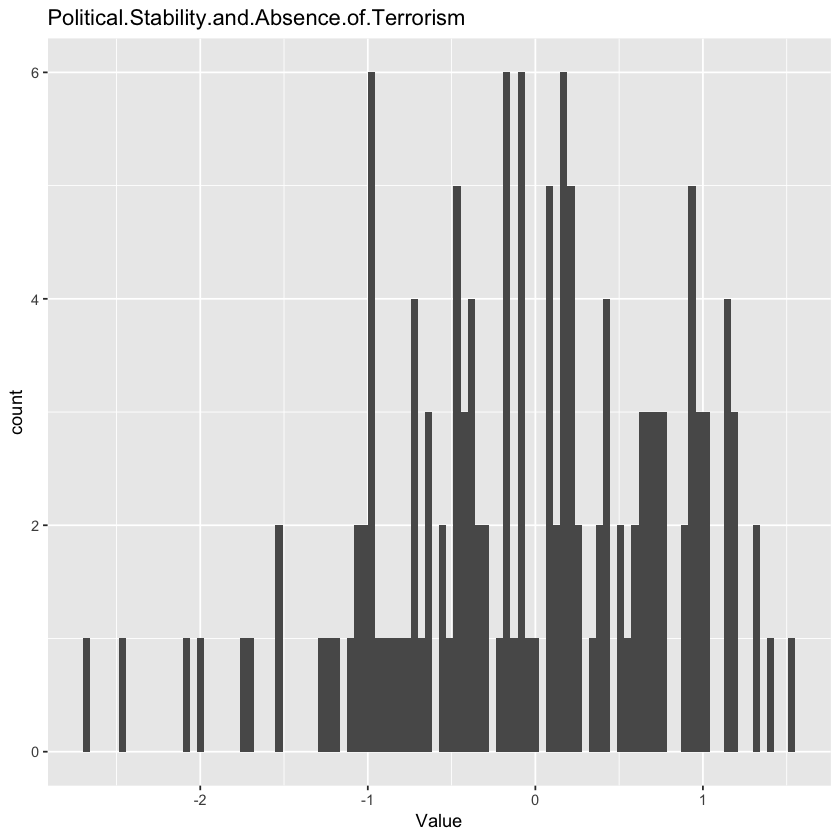

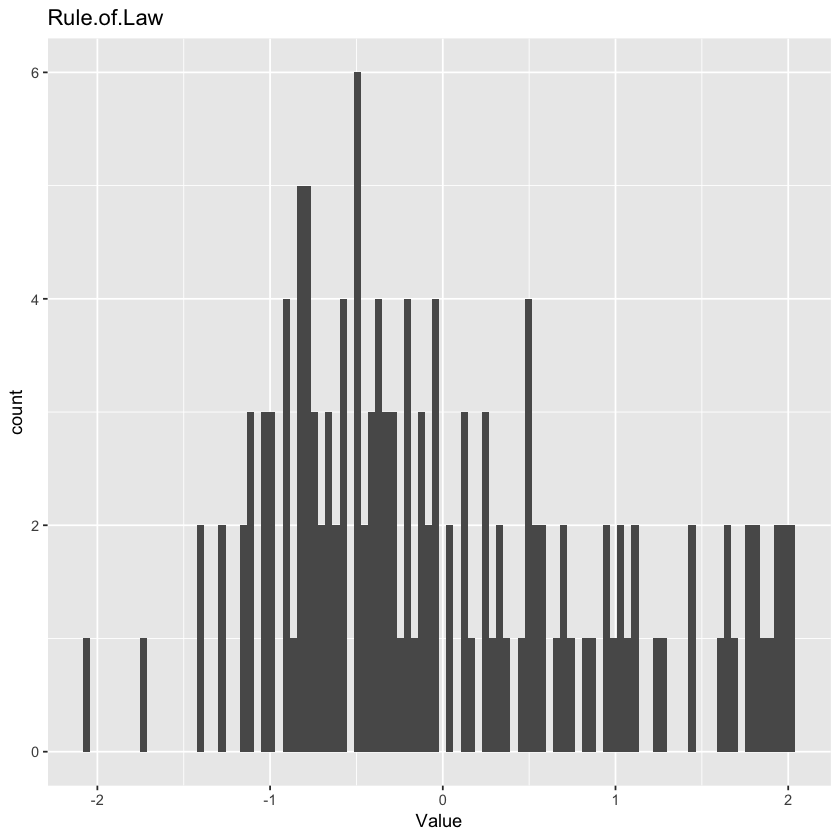

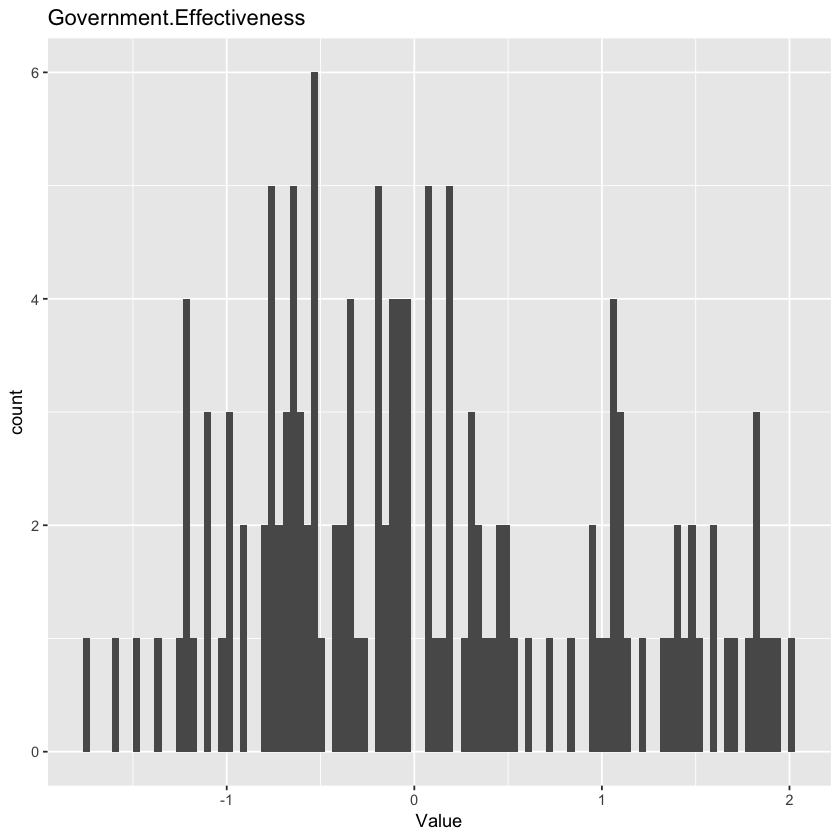

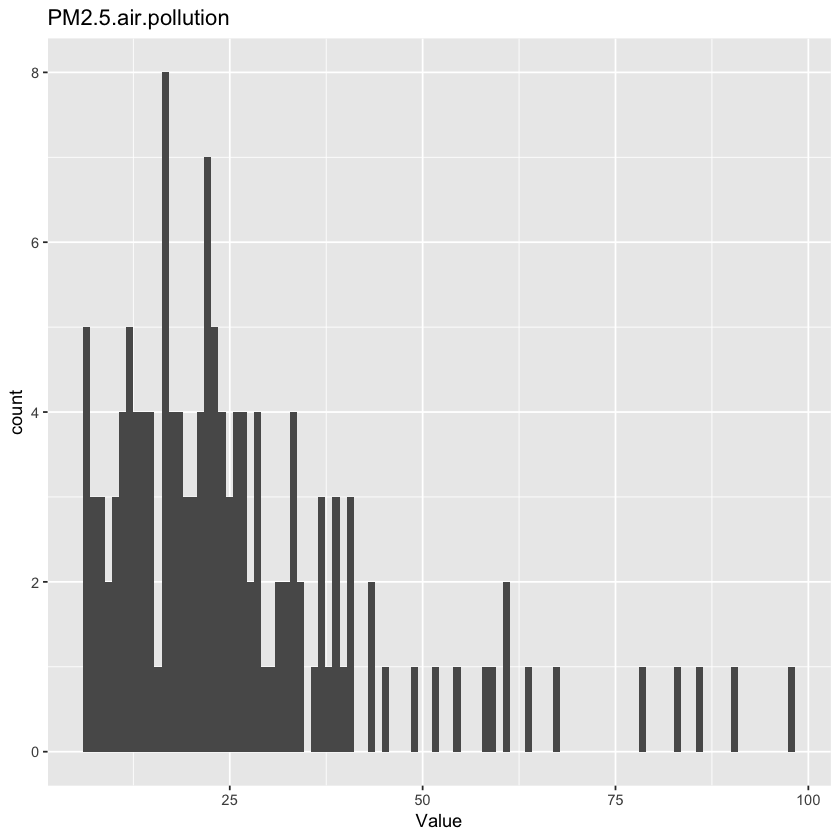

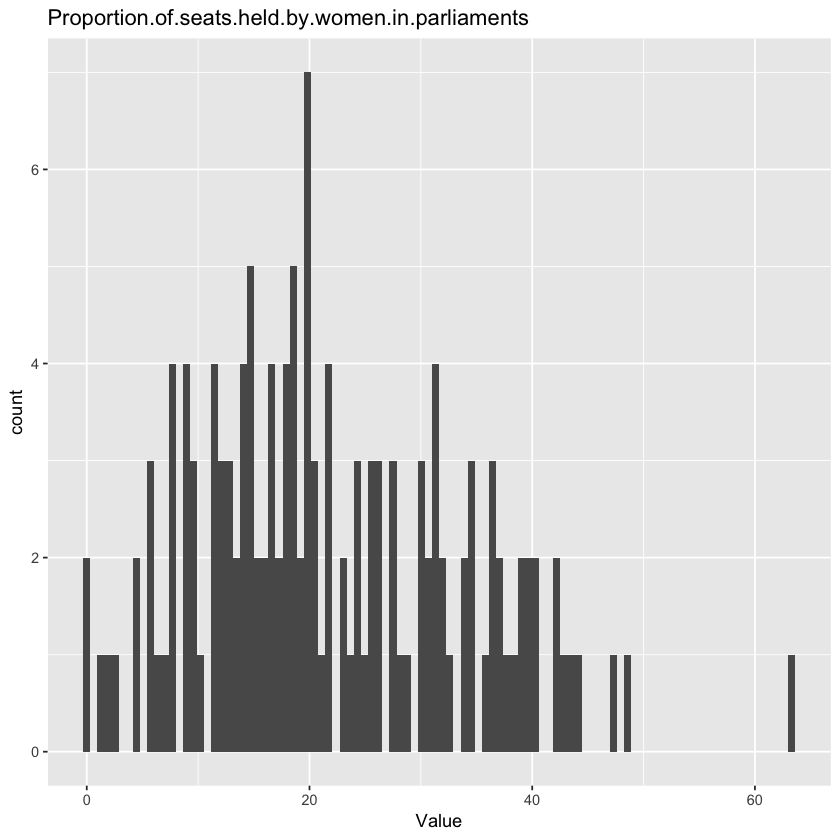

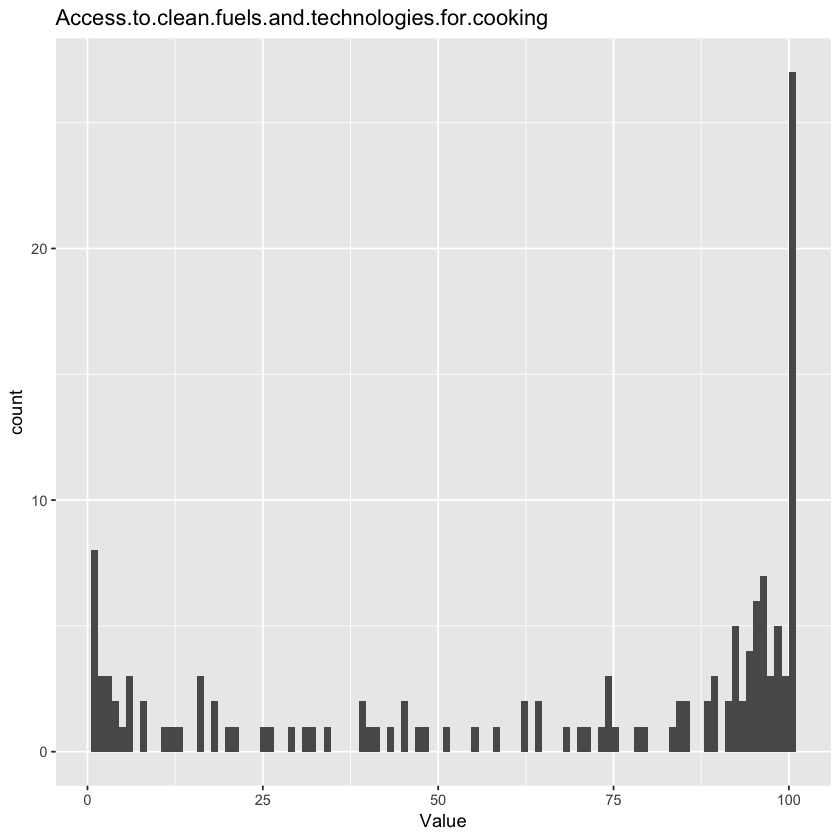

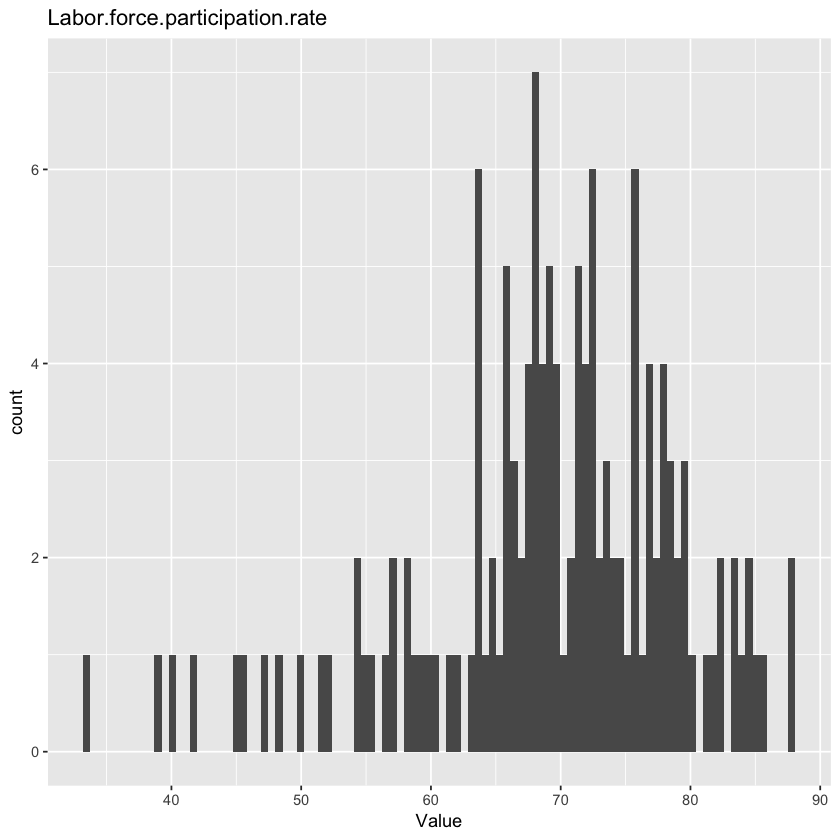

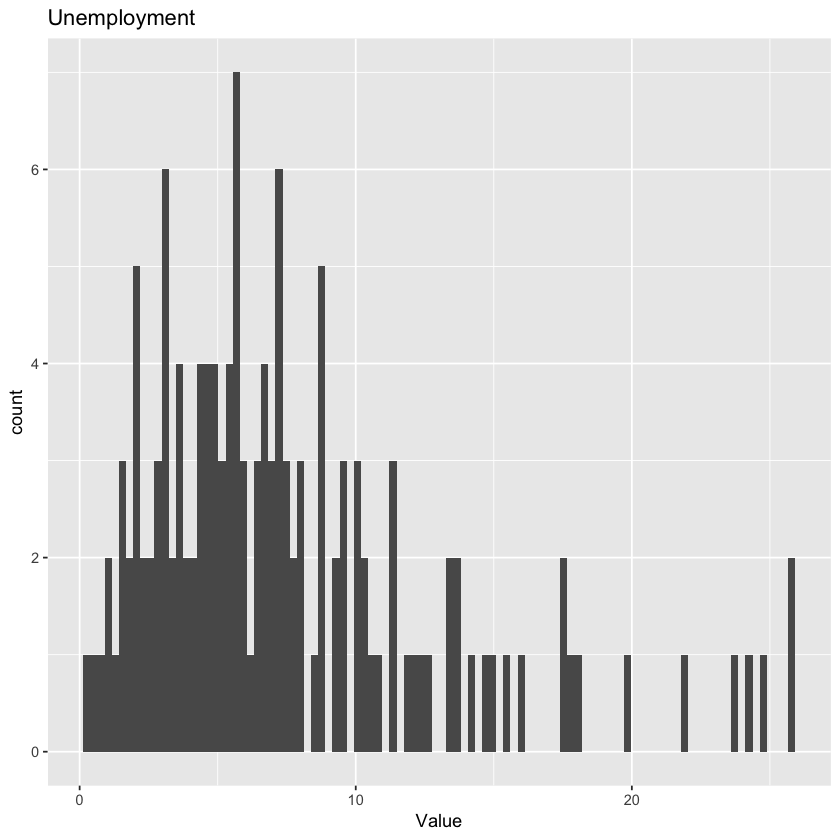

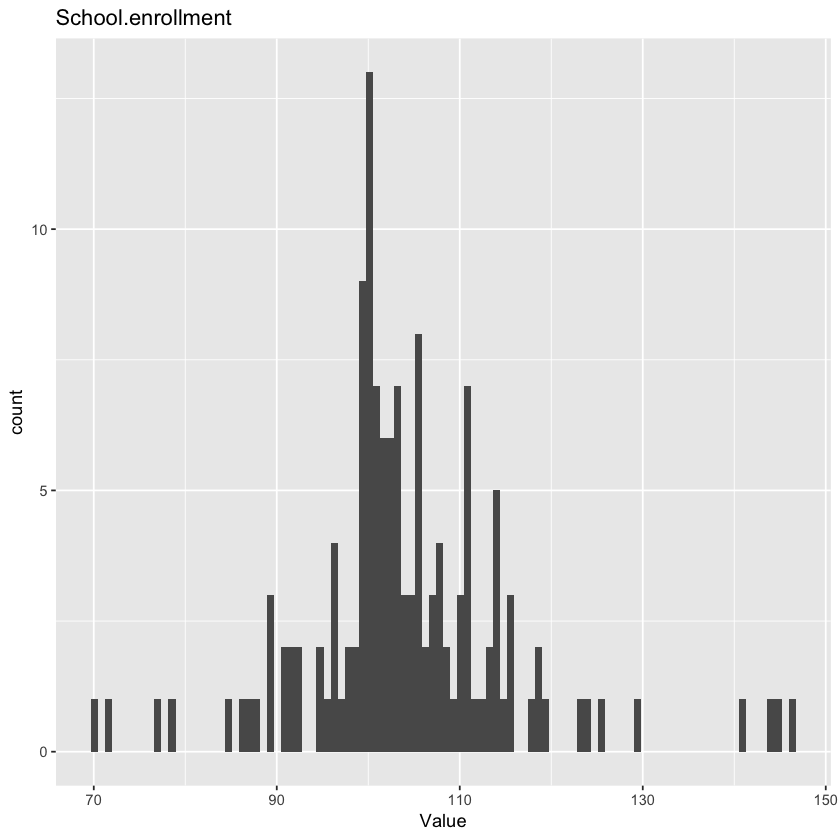

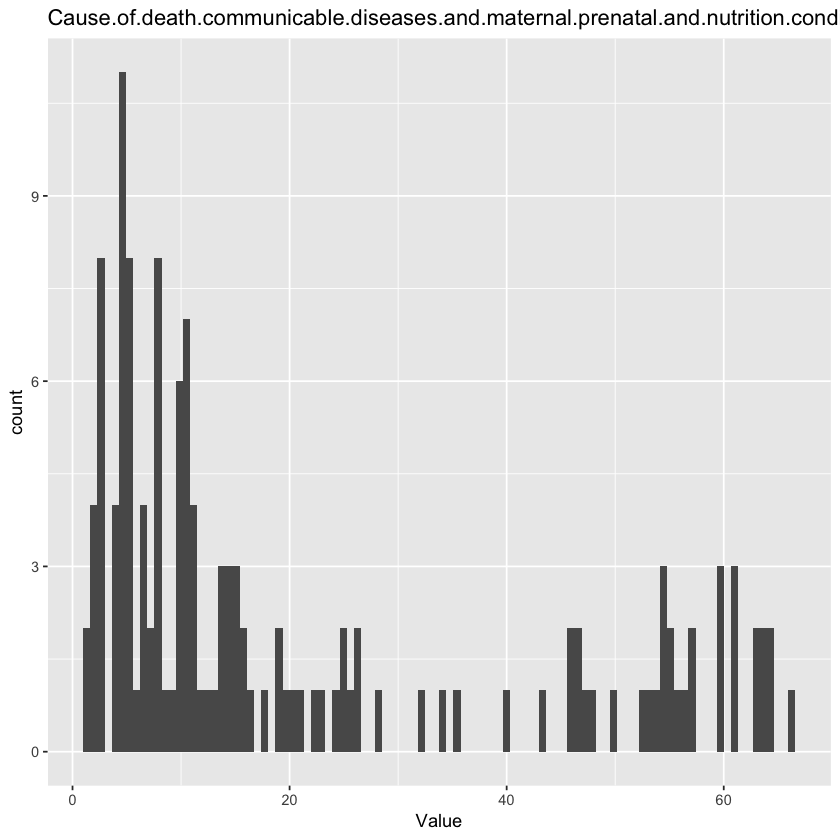

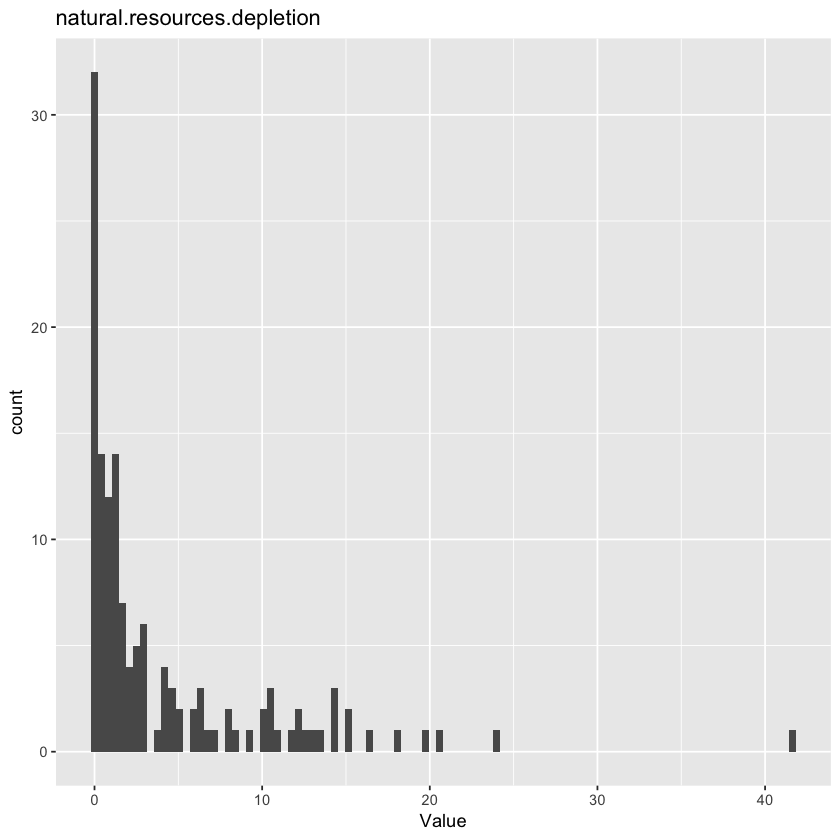

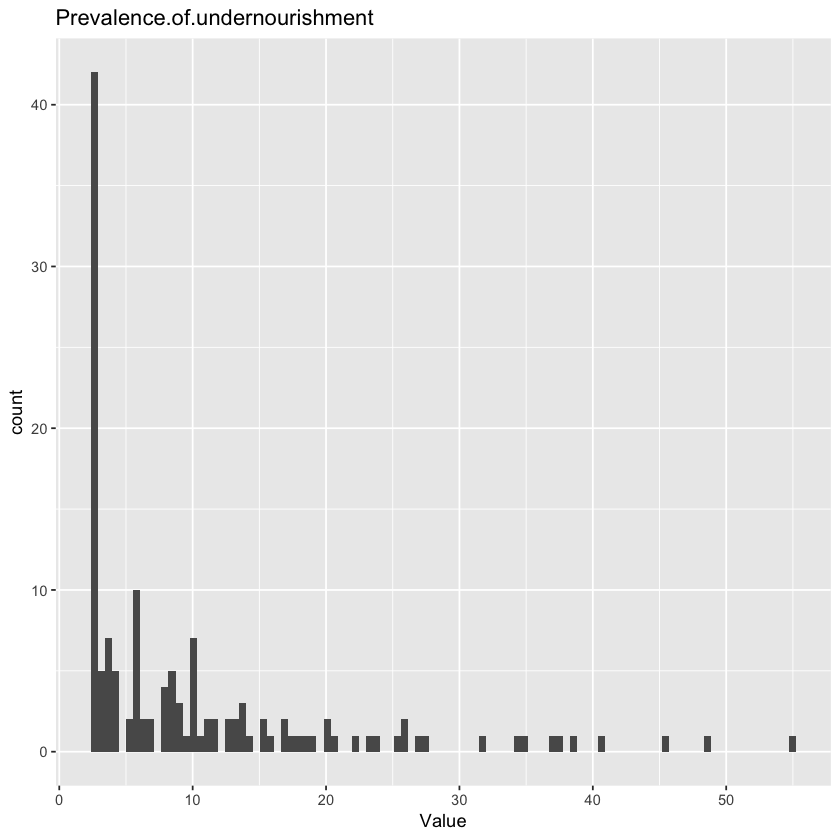

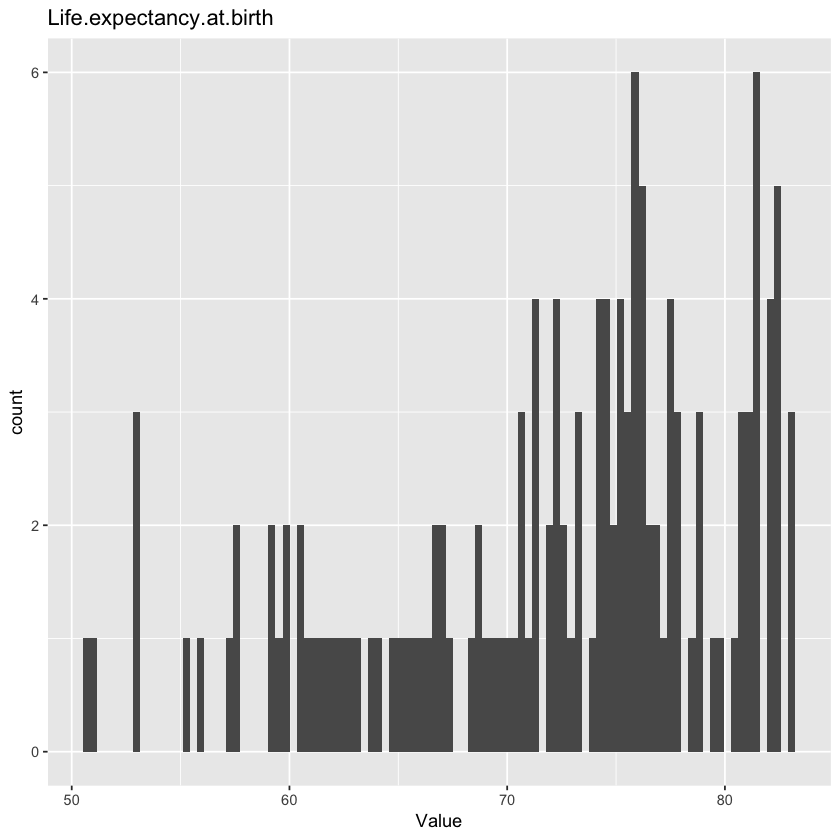

In [45]:
wb_select<-read.csv("../data/wb_tidy.csv", row.names = 1)
library(ggplot2)

check_skew<-gather(wb_select, Measure, Value, -Country)  # reshape the dataframe for plotting

for (i in unique(check_skew$Measure)){  #plot a histogram for each indicator
  plot<-ggplot(check_skew[check_skew$Measure==i,], aes(Value))+
    geom_histogram(bins = 100)+
    labs(title=paste(i))
  print(plot)
}

rm(check_skew) #remove this dataframe so it doesnt clutter our environment

Most of these variables are right skewed, so they could be transformed with a log transformation
## Below, some columns are log-transformed

In [28]:
wb_log<-wb_select%>%
  mutate_at(vars(Renewable.electricity.output, 
                 Renewable.energy.consumption, 
                 Terrestrial.and.marine.protected.areas, 
                 CO2.emissions, 
                 PM2.5.air.pollution, 
                 Unemployment, 
                 Cause.of.death.communicable.diseases.and.maternal.prenatal.and.nutrition.conditions, 
                 natural.resources.depletion,
                 Prevalence.of.undernourishment), ~log10(1+.))%>% # log after adding 1 to make all data positive
  mutate_at(vars(Access.to.electricity, 
                 Access.to.clean.fuels.and.technologies.for.cooking), ~log10(101-.)) 
# left skewed variable transformed after subtracted from 110 to turn it into a left skew

## Next, the data is re-scaled to a mean of 0 and a standard deviation of 1 because regression performs better on data that is uniformly scaled

In [29]:
wb_scaled<-wb_log%>%
  mutate_at(c('Renewable.electricity.output',
               'Access.to.electricity', 
               'Renewable.energy.consumption',
               'Terrestrial.and.marine.protected.areas', 
               'Agricultural.land',  
               'Individuals.using.the.Internet',
               'CO2.emissions', 
               'GDP.growth',
               'Political.Stability.and.Absence.of.Terrorism',
               'Rule.of.Law',
               'Government.Effectiveness',
               'PM2.5.air.pollution',
               'Proportion.of.seats.held.by.women.in.parliaments',
               'Access.to.clean.fuels.and.technologies.for.cooking',
               'Labor.force.participation.rate',
               'Unemployment',
               'School.enrollment',
               'Cause.of.death.communicable.diseases.and.maternal.prenatal.and.nutrition.conditions',
               'natural.resources.depletion',
               'Prevalence.of.undernourishment',
               'Life.expectancy.at.birth'), ~scale(.))

## Here we visualize the transformed data to make sure the transformation worked as anticipated

Warning message:
“attributes are not identical across measure variables;
they will be dropped”

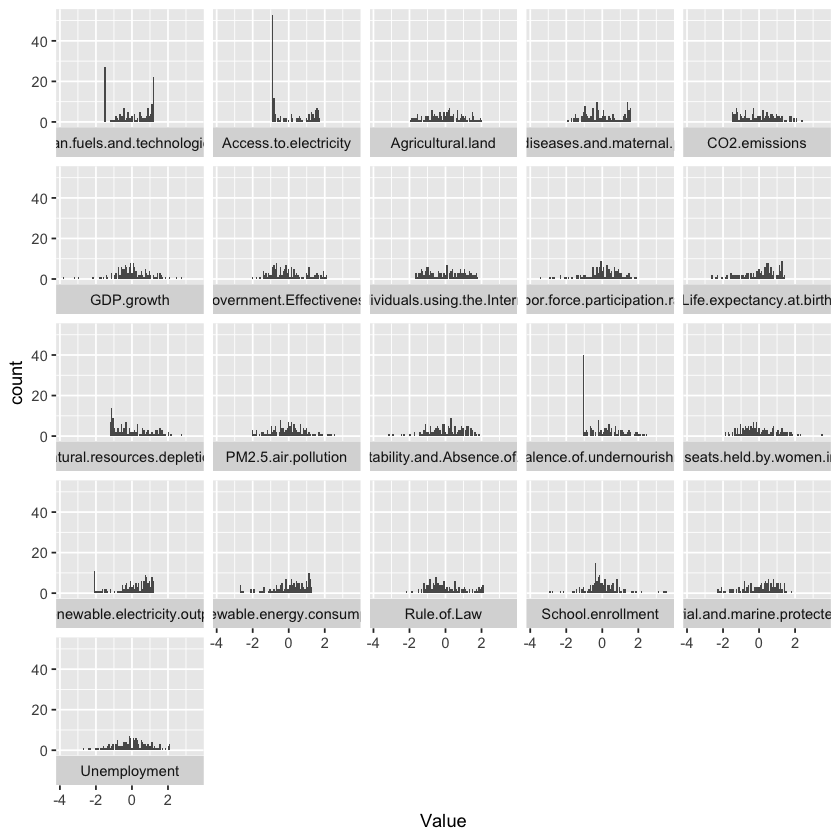

In [30]:
check_scaling<-gather(wb_scaled, Measure, Value, -Country) # re-shape for plotting
check_scaling$Measure<-as.factor(check_scaling$Measure) 

ggplot(check_scaling, aes(Value))+ # make histograms
  geom_histogram(bins = 100)+
  facet_wrap(~Measure,strip.position = "bottom")
rm(check_scaling) #remove this dataframe so it doesnt clutter our environment

Now the data looks way more normally distributed 
## Start exploring the data by visualizing the correlations between each variable

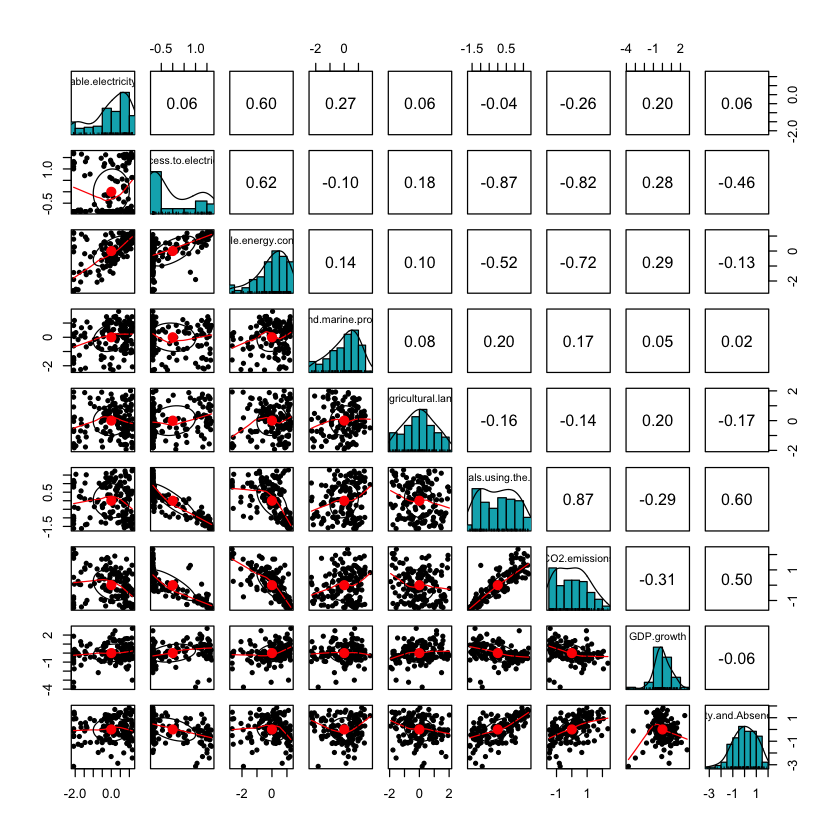

In [32]:
wb_transformed<-read.csv("../data/wb_transformed.csv",row.names = 1)
library(psych)
pairs.panels(wb_transformed[,2:10],
             method = "pearson",
             hist.col = "#00AFBB")

## Here is another way to visualize correlations that I like to use

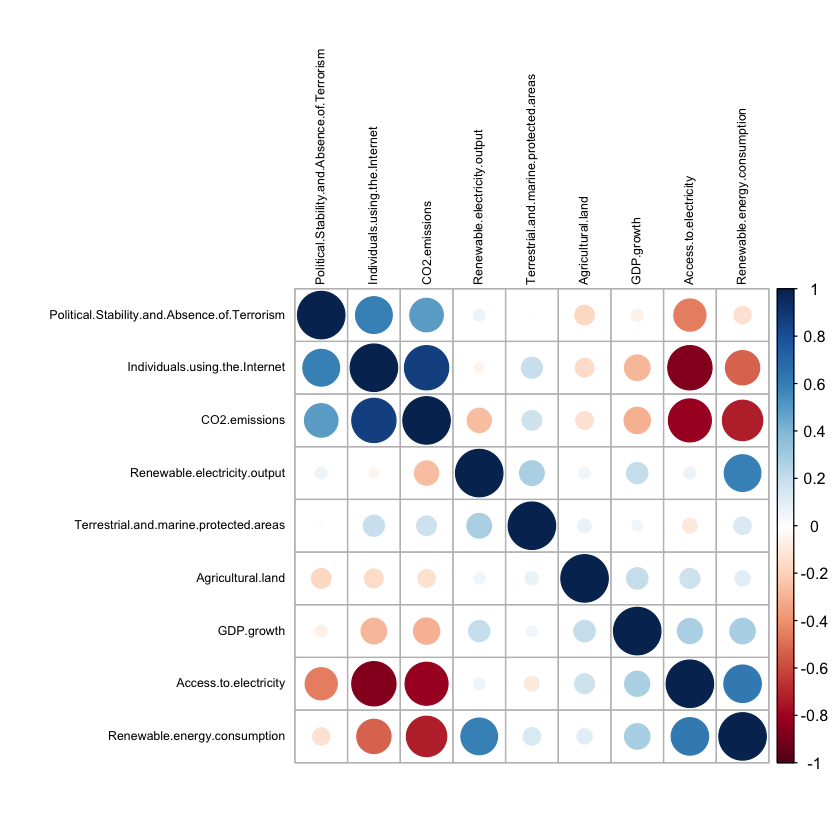

In [34]:
library(corrplot)
corrplot(cor(wb_transformed[2:10]),order="hclust",tl.col="black",tl.cex=.62)

## Because I am interested in the predicting life expectancy, I want to visualize the relationship between life expectancy and each of the other variables 

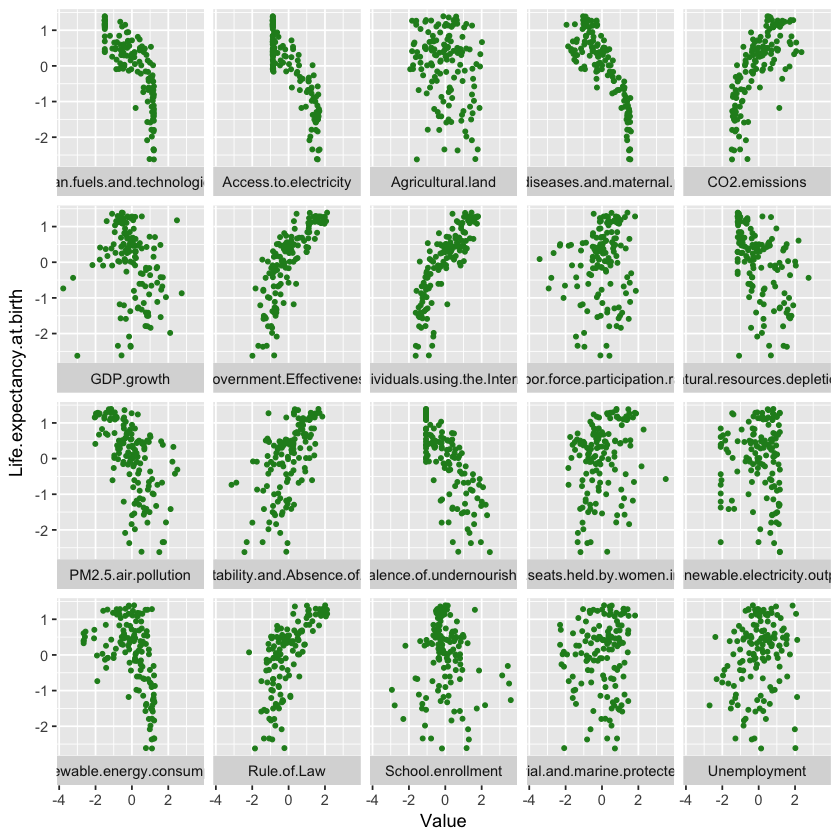

In [35]:
# re-shape the data for plotting
wb_long<-gather(wb_transformed, Measure, Value, -Country, -Life.expectancy.at.birth)
wb_long$Measure<-as.factor(wb_long$Measure)

ggplot(wb_long, aes(x=Value,y=Life.expectancy.at.birth))+
  geom_point(size=1,color='forestgreen')+
  facet_wrap(~Measure,strip.position = "bottom")

## Now it's time to make the multilinear model. 

I start by constructing a full model with all the variables

In [39]:
fullmodel<-lm(Life.expectancy.at.birth ~ 
                Renewable.electricity.output + 
                Access.to.electricity + 
                Renewable.energy.consumption + 
                Terrestrial.and.marine.protected.areas +
                Agricultural.land +
                Individuals.using.the.Internet +
                CO2.emissions +
                GDP.growth +
                Political.Stability.and.Absence.of.Terrorism +
                Rule.of.Law +
                Government.Effectiveness +
                PM2.5.air.pollution +
                Proportion.of.seats.held.by.women.in.parliaments +
                Access.to.clean.fuels.and.technologies.for.cooking +
                Labor.force.participation.rate +
                Unemployment +
                School.enrollment +
                Cause.of.death.communicable.diseases.and.maternal.prenatal.and.nutrition.conditions +
                natural.resources.depletion +
                Prevalence.of.undernourishment, data=wb_transformed)

Then, we use backward elimination to select the variables that are predictive of life expectancy

In [40]:
step(fullmodel,direction="backward",trace=10)

Start:  AIC=-238.85
Life.expectancy.at.birth ~ Renewable.electricity.output + Access.to.electricity + 
    Renewable.energy.consumption + Terrestrial.and.marine.protected.areas + 
    Agricultural.land + Individuals.using.the.Internet + CO2.emissions + 
    GDP.growth + Political.Stability.and.Absence.of.Terrorism + 
    Rule.of.Law + Government.Effectiveness + PM2.5.air.pollution + 
    Proportion.of.seats.held.by.women.in.parliaments + Access.to.clean.fuels.and.technologies.for.cooking + 
    Labor.force.participation.rate + Unemployment + School.enrollment + 
    Cause.of.death.communicable.diseases.and.maternal.prenatal.and.nutrition.conditions + 
    natural.resources.depletion + Prevalence.of.undernourishment

                                                                                      Df
- Terrestrial.and.marine.protected.areas                                               1
- Individuals.using.the.Internet                                                       1
- Preva


Call:
lm(formula = Life.expectancy.at.birth ~ Access.to.electricity + 
    Renewable.energy.consumption + Agricultural.land + CO2.emissions + 
    Government.Effectiveness + PM2.5.air.pollution + Proportion.of.seats.held.by.women.in.parliaments + 
    Unemployment + Cause.of.death.communicable.diseases.and.maternal.prenatal.and.nutrition.conditions + 
    natural.resources.depletion, data = wb_transformed)

Coefficients:
                                                                        (Intercept)  
                                                                         -7.823e-16  
                                                              Access.to.electricity  
                                                                         -4.478e-01  
                                                       Renewable.energy.consumption  
                                                                         -1.919e-01  
                                                          

## Backward elimination shows us the combination of variables that can be used to predict the life expectancy. 
Here, we assign this model to a new variable and inspect it closer to see which variables have the most significant relationship with life expectancy.

In [44]:
model = lm(Life.expectancy.at.birth ~ 
           Access.to.electricity + 
           Renewable.energy.consumption + 
           Agricultural.land + 
           CO2.emissions + 
           Government.Effectiveness + 
           PM2.5.air.pollution + 
           Proportion.of.seats.held.by.women.in.parliaments + 
           Unemployment + 
           Cause.of.death.communicable.diseases.and.maternal.prenatal.and.nutrition.conditions +
           natural.resources.depletion, data = wb_transformed)
summary(model)


Call:
lm(formula = Life.expectancy.at.birth ~ Access.to.electricity + 
    Renewable.energy.consumption + Agricultural.land + CO2.emissions + 
    Government.Effectiveness + PM2.5.air.pollution + Proportion.of.seats.held.by.women.in.parliaments + 
    Unemployment + Cause.of.death.communicable.diseases.and.maternal.prenatal.and.nutrition.conditions + 
    natural.resources.depletion, data = wb_transformed)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.0404 -0.2135  0.0107  0.2500  0.9221 

Coefficients:
                                                                                      Estimate
(Intercept)                                                                         -7.823e-16
Access.to.electricity                                                               -4.478e-01
Renewable.energy.consumption                                                        -1.919e-01
Agricultural.land                                                                   -9.140e-02
CO2.e

## Here, we inspect the residuals of the model
It's important to inspect the residuals of the model. If they aren't normally distributed or follow a non-linear pattern, this indicates that the model is not fit optimally. 

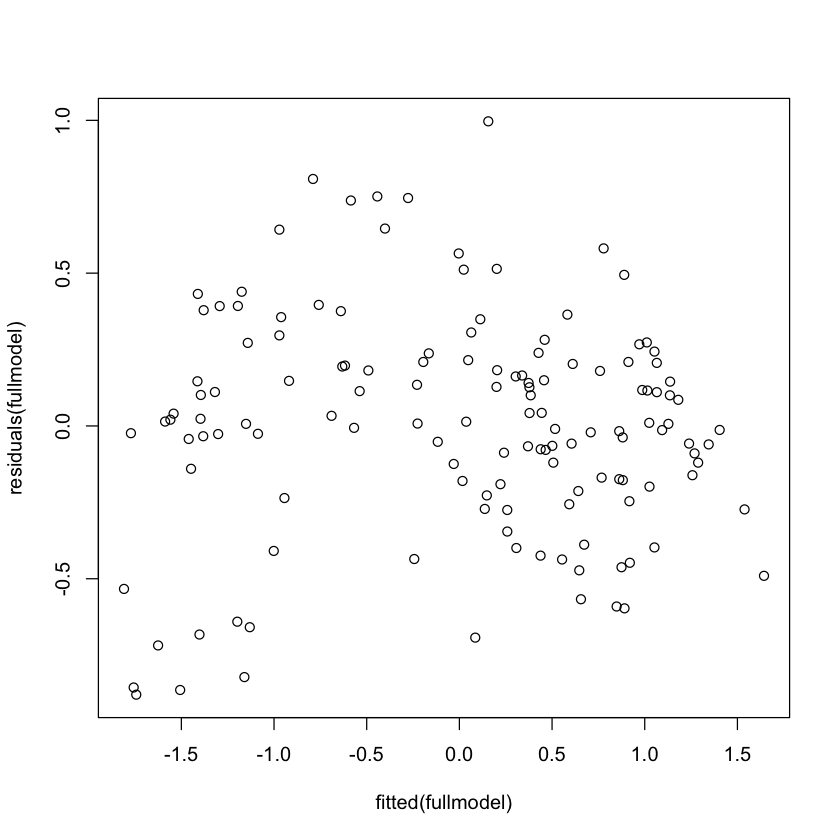

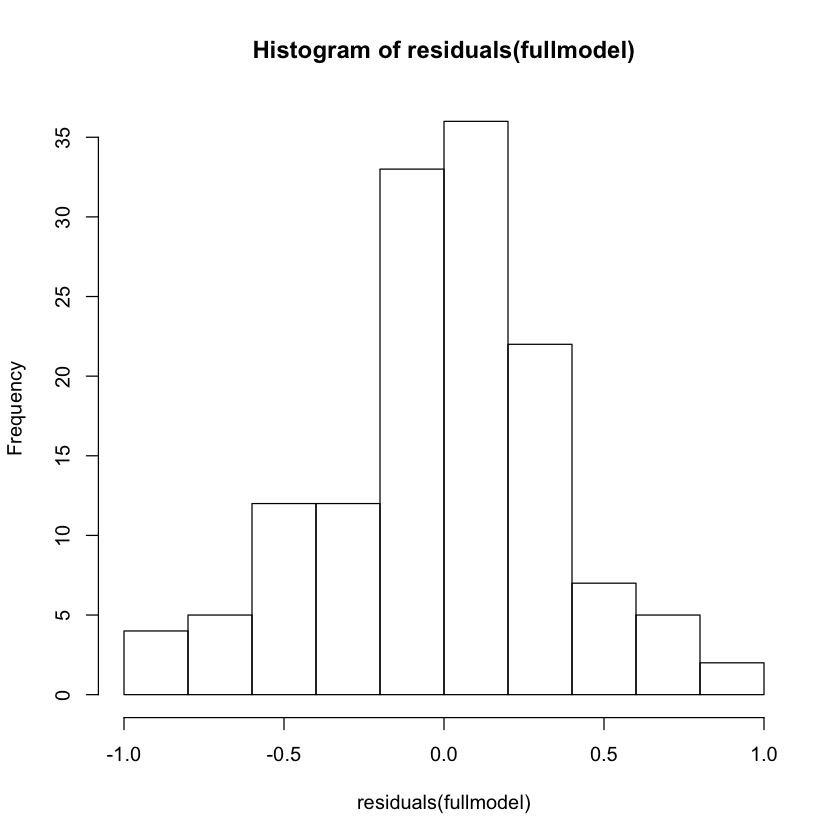

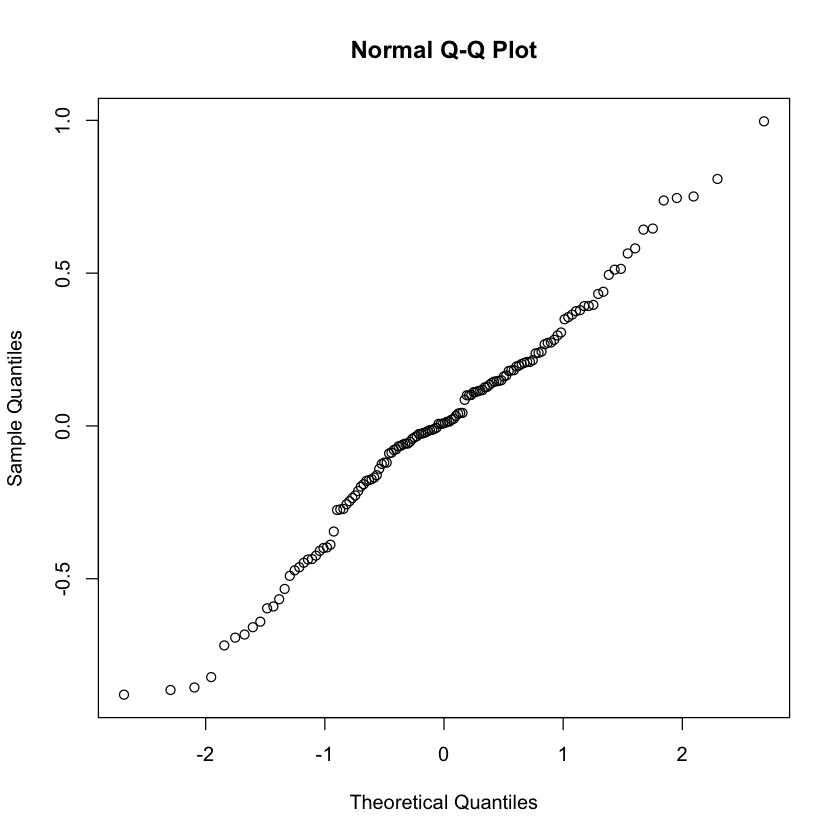

In [41]:
plot(fitted(model),residuals(model)) # with this plot, we are look for absence of a pattern
hist(residuals(model)) # with the histogram, we're looking for a normal distribution
qqnorm(residuals(model)) # with the qqnorm plot, we are looking for a straight line